In [1]:
import pickle 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timezone

In [2]:
g = nx.read_edgelist('final.edgelist',create_using=nx.DiGraph)

In [5]:
g.number_of_nodes(), g.number_of_edges()

(3409, 13504)

By removing the central node, 2143 disconnected components are created.
among them, 2140 are isolated accounts.
largest (undirected) connected component
n: 1264 m: 8142


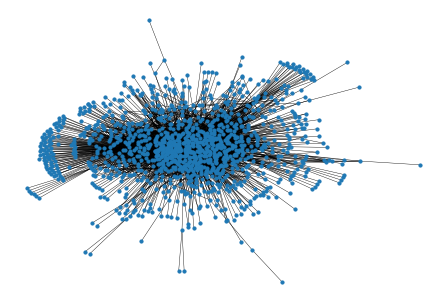

In [48]:
g_test = g.copy()
g_test.remove_node('806344552718045184')
g_test = g_test.to_undirected()
c = 0 
disconnected = []
print('By removing the central node,', nx.number_connected_components(g_test), 'disconnected components are created.')
for i in g_test.nodes():
    if g_test.degree[i]==0:
#         print(i)
        disconnected.append(i)
print('among them,', len(disconnected), 'are isolated accounts.')
g_test.remove_nodes_from(disconnected)
connected_ego = g_test.subgraph(max(nx.connected_components(g_test), key=len))
print('largest (undirected) connected component')
nx.draw(connected_ego, node_size=10, width=0.4)
print('n:', connected_ego.number_of_nodes(), 'm:', connected_ego.number_of_edges())

## degree distributions

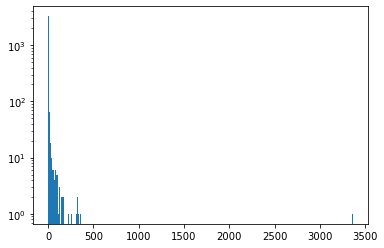

In [15]:
plt.hist(dict(g.in_degree).values(), bins=300)
plt.yscale('log')
plt.show()

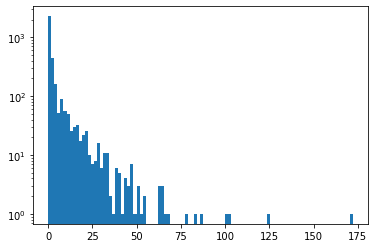

In [17]:
plt.hist(dict(g.out_degree).values(), bins=100)
plt.yscale('log')
plt.show()

806344552718045184


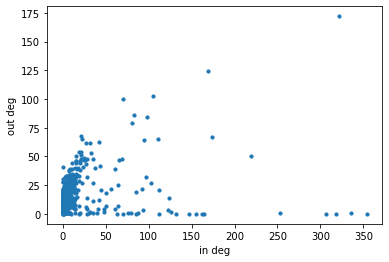

In [22]:
xs, ys = [], []
for i in g.nodes():
    if g.in_degree[i]>3000:
        print(i)
        continue
    xs.append(g.in_degree[i])
    ys.append(g.out_degree[i])
plt.scatter(xs, ys, s=10)
plt.xlabel('in deg')
plt.ylabel('out deg')
plt.show()

## Check opinions

In [3]:
import json
 
# Opening JSON file
with open('vax_final.json') as json_file:
    data = json.load(json_file)

## Central node, a doctor against vax.

In [ ]:
data['806344552718045184']

## Polarity of her tweets by time. All of them are supposed to be negative but we only see a few.

positive tweet id 1485400176432984066
negative tweet id 1425125968725913604
positive tweet id 1424330768340459521
positive tweet id 1334599972344324101


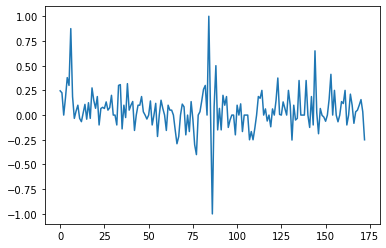

In [58]:
def dict_to_timestamp(create_time):
    d = date(create_time['year'], create_time['month'], create_time['day'])
    t = time(create_time['hour'], create_time['minute'], create_time['second'])
    dt = datetime.combine(d, t)
    return datetime.timestamp(dt)

ys = {}
for i in data['806344552718045184']:
    create_time = i['created_at']
    timestamp = dict_to_timestamp(create_time)
    ys[timestamp] = i['polarity']
    if i['polarity']<-0.5:
        print('negative tweet id', i['tweet_id'])
    if i['polarity']>0.5:
        print('positive tweet id', i['tweet_id'])
    
ys = dict(sorted(ys.items())).values()
# print(ys)
plt.plot([i for i in range(len(ys))], ys)
plt.show()

## One example of tweet with  negative polarity and against vax

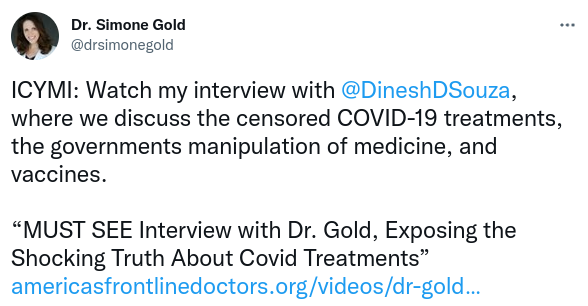

## One example of tweet with  positive polarity but against vax

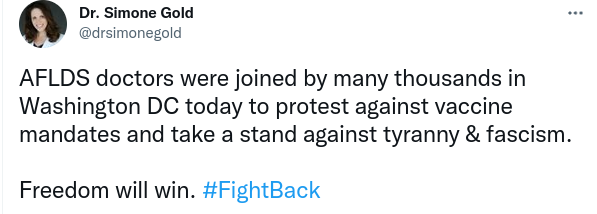

## See the last two sections for DL models.

## Average polarity histogram of all accounts.

In [30]:
avg_opinions = {}
stable = {}
for i in data:
    tmp_l = []
    for j in data[i]:
        tmp_l.append(j['polarity'])
    tmp_l = np.array(tmp_l)
    if len(tmp_l[tmp_l!=0])==0:
        stable[i] = -1
    else:
        stable[i] = len(tmp_l[tmp_l>0])/len(tmp_l[tmp_l!=0])
    avg_opinions[i] = np.average(tmp_l)

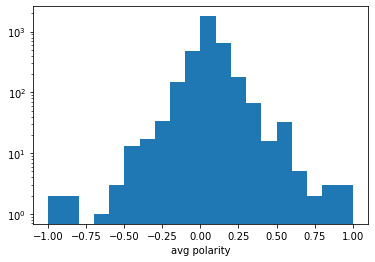

In [49]:
plt.hist(avg_opinions.values(), bins=20)
plt.yscale('log')
plt.xlabel('avg polarity')
plt.show()

## percentage of  polarity that are positive for each account. -1 if all neutral.

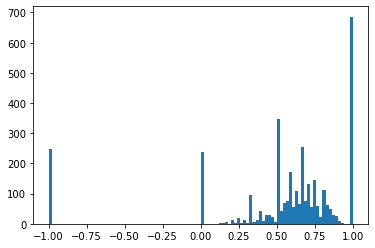

In [36]:
plt.hist(stable.values(),bins=100)
# plt.yscale('log')
# plt.xlabel('avg polarity')
plt.show()

## Glove+GRU

https://github.com/shahules786/Twitter-Sentiment

In [2]:
from twittersentiment import TwitterSentiment

In [3]:
sent = TwitterSentiment.Sentiment()
sent.load_pretrained()
sent.predict("you filthy animal!")

array(0.99930847, dtype=float32)

In [3]:
sent.predict("This food is good")

array(4.2026312e-07, dtype=float32)

In [8]:
sent.predict("ICYMI: Watch my interview with @DineshDSouza, where we discuss the censored COVID-19 treatments, the governments manipulation of medicine, and vaccines.“MUST SEE Interview with Dr. Gold, Exposing the Shocking Truth About Covid Treatments”")

array(0.96064967, dtype=float32)

In [4]:
sent.predict("AFLDS doctors were joined by many thousands in Washington DC today to protest against vaccine mandates and take a stand against tyranny & fascism. Freedom will win. #FightBack")

array(0.99986863, dtype=float32)

In [5]:
sent.predict("Well, there will be less anti-vaxxers in about 4-6 weeks that's for sure.  Sad that it has to happen, but you can't force science onto ignorance.")

array(1., dtype=float32)

## Use big model from NLPCloud

They also have few-shot learning if we want to fine-tune on specific topic: https://nlpcloud.io/effectively-using-gpt-j-gpt-neo-gpt-3-alternatives-few-shot-learning.html

In [4]:
import nlpcloud

client = nlpcloud.Client("distilbert-base-uncased-finetuned-sst-2-english", "890d5fce2291b930fc8c823d2c0cfc70827a5f5a", gpu=False, lang="en")
client.sentiment("Let's go vax!")

{'scored_labels': [{'label': 'NEGATIVE', 'score': 0.9840332865715027}]}

In [5]:
s = "Well, there will be less anti-vaxxers in about 4-6 weeks that's for sure.  Sad that it has to happen, but you can't force science onto ignorance."
client.sentiment(s)

{'scored_labels': [{'label': 'NEGATIVE', 'score': 0.9867134094238281}]}

In [6]:
s = "ICYMI: Watch my interview with @DineshDSouza, where we discuss the censored COVID-19 treatments, the governments manipulation of medicine, and vaccines.“MUST SEE Interview with Dr. Gold, Exposing the Shocking Truth About Covid Treatments”"
client.sentiment(s)

{'scored_labels': [{'label': 'POSITIVE', 'score': 0.925419270992279}]}

In [7]:
client.sentiment("AFLDS doctors were joined by many thousands in Washington DC today to protest against vaccine mandates and take a stand against tyranny & fascism. Freedom will win. #FightBack")


{'scored_labels': [{'label': 'POSITIVE', 'score': 0.9950264692306519}]}